## Loading Datsets

In [1]:
import os
from nltk import word_tokenize
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
# OS library walk function iterates directories 
rootdir = "/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare"

for directories, subdirs, files in os.walk(rootdir):
    print(directories, subdirs, len(files))

/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare ['part3', 'part4', 'part5', 'part2', 'part10', 'part9', 'part7', 'part1', 'part6', 'part8', '.ipynb_checkpoints'] 2
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part3 ['spam', 'ham'] 1
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part3/spam [] 49
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part3/ham [] 242
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part4 ['spam', 'ham'] 1
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part4/spam [] 49
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part4/ham [] 242
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/LingSpam/lingspam_public/bare/part5 ['spam', 'ham'] 1
/Users/muzammil/

In [3]:
ham_list = [] # empty ham list
spam_list = [] # empty spam list

for directories, subdirs, files in os.walk(rootdir):
    if (os.path.split(directories)[1]  == 'ham'):
        for filename in files:      
            # Opening ham folders and appending ham emails from the folder into the ham_list
            with open(os.path.join(directories, filename), encoding="latin-1") as f:
                text = f.read()
                ham_list.append(text)

    if (os.path.split(directories)[1]  == 'spam'):
       for filename in files:      
            # Opening spam folders and appending spam emails from the folder into the spam_list
            with open(os.path.join(directories, filename), encoding="latin-1") as f:
                text = f.read()
                spam_list.append(text)

spam_ones = [1] * len(spam_list); # making empty list of ones
ham_zeros = [0] * len(ham_list); # making empty list of zeros

# Creating dataframe using pandas, dataframe has the email content and 1 in spam column if email is spam or zero if not spam
dfSpam = pd.DataFrame(
    {'Spam': spam_ones,
    'Email': spam_list
    })
dfHam = pd.DataFrame(
    {'Spam': ham_zeros,
    'Email': ham_list
    })

dfTotal = pd.concat([dfHam, dfSpam])
dfTotal.head(10)

,Spam,Email
0,0,Subject: job posting - apple-iss research cent...
1,0,"Subject: \n\nlang classification grimes , jose..."
2,0,Subject: query : letter frequencies for text i...
3,0,Subject: risk\n\na colleague and i are researc...
4,0,Subject: request book information\n\nearlier t...
5,0,Subject: call for abstracts : optimality in sy...
6,0,Subject: m . a . in scandinavian linguistics\n...
7,0,Subject: call for papers : linguistics session...
8,0,Subject: foreign language in commercials\n\nco...
9,0,Subject: fulbright announcement : please post ...


In [4]:
# Randomizing dataframe so classifier is not biased, Resetting indexes for the dataframe, replacing number occurences 
from sklearn.utils import shuffle

dfTotal = shuffle(dfTotal,random_state=0)
dfTotal = dfTotal.reset_index(drop=True);
dfTotal = dfTotal.replace('\d+', 'and', regex=True)
dfTotal.head(10)

,Spam,Email
0,0,Subject: query : email addresses\n\ndoes anybo...
1,1,"Subject: great job !\n\nadults only nothing "" ..."
2,0,Subject: gala ' and proceedings ( change of ad...
3,1,Subject: free software ! ! !\n\nhello - = and ...
4,0,Subject: amta workshop on embedded mt systems ...
5,0,Subject: feminine he\n\nfeminine he ouch ! no ...
6,0,Subject: kbcs-and andnd call for papers\n\nk b...
7,0,Subject: palatal on-glides\n\ndoes anyone know...
8,0,Subject: books on terminology\n\njohn benjamin...
9,0,Subject: position : computational linguist\n\n...


## Training test split

In [5]:
# dividing dataset into training and testing split

from sklearn.model_selection import train_test_split

# split 70% train, 30% test

email_train,email_test,spam_train,spam_test = train_test_split(dfTotal.Email,dfTotal.Spam,test_size=0.3,random_state=0)

# 70% * 1/3.5 = 20% #validation split 
email_train,email_val,spam_train,spam_val = train_test_split(email_train,spam_train,test_size=(1/3.5),random_state=0)

In [6]:
email_train.head(10)

1502    Subject: new on and . and capital fm\n\nthis i...
2841    Subject: ceth summer seminar on electronic tex...
95      Subject: unlimited cash & millions in your mai...
2390    Subject: re : and . and chomsky citations\n\ni...
695     Subject: list of language lists version and . ...
1257    Subject: pdt\n\nsend for a free sample copy of...
1676    Subject: qs : syllabus for english linguistics...
1806    Subject: second language acquisition\n\n* * * ...
2563    Subject: conference program ( ling . symp . & ...
2740    Subject: language policy\n\nadmittedly , i ' m...
Name: Email, dtype: object

In [7]:
email_test.head(10)

1728    Subject: english only ?\n\nenglish only ? this...
2684    Subject: sum : lang . www sites\n\ncontent - l...
1151    Subject: ucla tesl & applied linguistics gophe...
2757    Subject: functions of language www home page\n...
1180    Subject: yuen ren society conference\n\nannual...
2219    Subject: just released vol . and\n\njust relea...
553     Subject: aaas ' and\n\nannouncement - - the am...
104     Subject: hil phonology and ( hilp and )\n\ncal...
1190    Subject: position announcement / instructor\n\...
2303    Subject: rmmla / ads\n\n* * * * * * * * papers...
Name: Email, dtype: object

In [8]:
#bag of words on training set for both spam & ham
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction import text 

# add additional email stop words
email_stop_words = ['subject','cc']
stop_words = text.ENGLISH_STOP_WORDS.union(email_stop_words)

cv = CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0);

email_train_dtm = cv.fit_transform(email_train)

In [9]:
# Converting countVectorizer Dataframe to TF-IDF object

from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()
email_train_tf = tf.fit_transform(email_train_dtm)

In [10]:
email_train_tf

<1456x17072 sparse matrix of type '<class 'numpy.float64'>'
	with 213294 stored elements in Compressed Sparse Row format>

### Initial classfiers

In [11]:
# dtm/BOW setup for 
email_test_dtm = cv.transform(email_test)
# convert to TFIDF form
email_test_tf = tf.fit_transform(email_test_dtm)
email_test_tf

<874x17072 sparse matrix of type '<class 'numpy.float64'>'
	with 122405 stored elements in Compressed Sparse Row format>

In [12]:
# dtm/BOW setup for val
email_val_dtm = cv.transform(email_val)

# convert to TFIDF form
email_val_tf = tf.fit_transform(email_val_dtm)
email_val_tf

<583x17072 sparse matrix of type '<class 'numpy.float64'>'
	with 82530 stored elements in Compressed Sparse Row format>

## ARTIFICIAL BEE COLONY

## Optunity

In [16]:
import optunity
import optunity.metrics

"""
See the documentation for more info : https://optunity.readthedocs.io/en/latest/
"""

/anaconda3/lib/python3.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


'\nSee the documentation for more info : https://optunity.readthedocs.io/en/latest/\n'

## Naive Bayes

In [65]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# fit tf-idf representation to NB model
nb.fit(email_train_tf, spam_train)


# class predictions for VALIDATION set
result1 = nb.predict(email_val_tf)

In [66]:
from sklearn import metrics

print("Accuracy on VALIDATION set:")
print(metrics.accuracy_score(spam_val, result1))
print (metrics.confusion_matrix(spam_val, result1))

Accuracy on VALIDATION set:
0.9468267581475128
[[490   0]
 [ 31  62]]


In [19]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9996708360763661


ValueError: Classification metrics can't handle a mix of binary and continuous targets

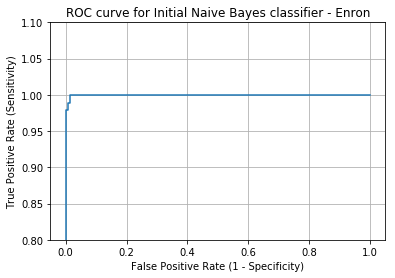

In [113]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = nb.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Naive Bayes classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
nb_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)
print(metrics.precision_score(spam_val, y_pred_prob))

### Tuning NB using grid search 

In [22]:
%%time
## Tuned NB
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-2, 2, 100) }
clf = GridSearchCV(MultinomialNB(), param_grid, cv= 5)
clf.fit(email_train_tf, spam_train)
best_alpha = clf.best_estimator_.alpha
print(" Best score: ", clf.best_score_ )
nb_grid_acc = clf.best_score_
print("alpha hyperparameter for best score: ", best_alpha)

 Best score:  0.9883241758241759
alpha hyperparameter for best score:  0.023101297000831605
CPU times: user 3.08 s, sys: 23.9 ms, total: 3.1 s
Wall time: 3.11 s


In [23]:
TunedNB = MultinomialNB(alpha = 0.023101297000831605)

In [24]:
TunedNB.fit(email_train_tf, spam_train)

MultinomialNB(alpha=0.023101297000831605, class_prior=None, fit_prior=True)

In [25]:
result1a = TunedNB.predict(email_val_tf)

In [26]:
from sklearn import metrics

print("Accuracy on validation set:")
print(metrics.accuracy_score(spam_val, result1a))
nb_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on validation set:
0.9914236706689536


In [27]:
from sklearn import metrics

print("Accuracy on validation set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on validation set:
0.9914236706689536
[[487   3]
 [  2  91]]


In [28]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.999670836076366


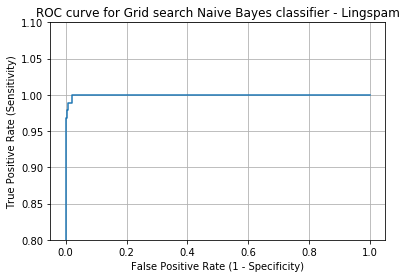

In [31]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = TunedNB.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid search Naive Bayes classifier - Lingspam')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
nb_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning NB using random search 

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
%%time
clf = MultinomialNB()
param_dist = {'alpha': np.logspace(-3, 3, 100) }
rand = RandomizedSearchCV(clf, param_dist, cv = 10, scoring = 'accuracy', n_iter = 50, random_state= 5)
rand.fit(email_train_tf, spam_train)
best_a = rand.best_estimator_.alpha
print(" Best score: ", rand.best_score_)
print(rand.best_estimator_.alpha)

 Best score:  0.9896978021978022
0.004641588833612782
CPU times: user 3.1 s, sys: 58.8 ms, total: 3.16 s
Wall time: 3.16 s


In [48]:
TunedNB = MultinomialNB(alpha = best_a)

In [49]:
TunedNB.fit(email_train_tf, spam_train)

MultinomialNB(alpha=0.024770763559917114, class_prior=None, fit_prior=True)

In [50]:
result1a = TunedNB.predict(email_val_tf)

In [51]:
from sklearn import metrics

print("Accuracy on val set:")
print(metrics.accuracy_score(spam_val, result1a))


Accuracy on val set:
0.9914236706689536


### Optunity

### SVM

In [67]:
import sklearn
from sklearn.svm import SVC
clf = SVC(kernel="rbf", probability=True)

# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = clf.predict(email_val_tf)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [68]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
svm_default = metrics.accuracy_score(spam_val, result1)
print (metrics.confusion_matrix(spam_val, result1))

Accuracy on test set:
0.8404802744425386
[[490   0]
 [ 93   0]]


In [69]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9992977836295809


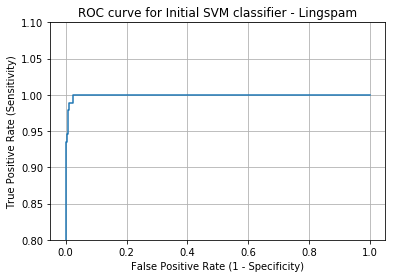

In [70]:
#ROC curve

y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial SVM classifier - Lingspam')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
svm_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning SVM using grid search 

In [71]:
%%time
from sklearn.model_selection import GridSearchCV
clf = SVC(kernel="rbf")
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_


print( grid_search.best_params_)


{'C': 10, 'gamma': 0.1}
CPU times: user 2min 24s, sys: 666 ms, total: 2min 24s
Wall time: 2min 26s


In [72]:
tunedSVM = SVC(gamma = 0.1, C = 10.0, kernel="rbf", probability=True)

In [73]:
tunedSVM.fit(email_train_tf, spam_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [74]:
result1a = tunedSVM.predict(email_val_tf)

In [75]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
svm_grid_acc= metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9897084048027445


In [77]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

[[490   0]
 [  6  87]]


0.9921726928123633


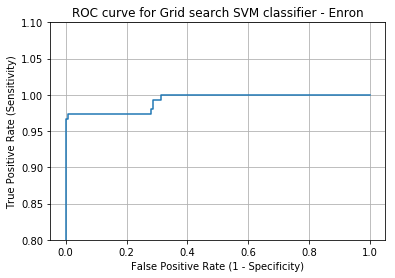

In [78]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedSVM.predict_proba(email_test_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_test, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid search SVM classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_test, y_pred_prob))
svm_grid_auc = metrics.roc_auc_score(spam_test, y_pred_prob)

### Tuning SVM using random search 

In [94]:
%%time
from sklearn.model_selection import RandomizedSearchCV
clf = SVC(kernel="rbf")
Cs = 10. ** np.arange(-3, 10)
gammas = 10. ** np.arange(-5, 4)
param_dist = {'C': Cs, 'gamma' : gammas}
rand = RandomizedSearchCV(clf, param_dist, cv = 5, scoring = 'accuracy', n_iter = 10, random_state= 5)
rand.fit(email_train_tf, spam_train)
rand.best_params_
print( rand.best_params_)
best_gamma = rand.best_estimator_.gamma
best_C = rand.best_estimator_.C

{'gamma': 0.1, 'C': 10000000.0}
CPU times: user 1min 27s, sys: 301 ms, total: 1min 27s
Wall time: 1min 29s


In [99]:
tunedSVM = SVC(gamma = 0.1, C = 10000, kernel="rbf")

In [100]:
tunedSVM.fit(email_train_tf, spam_train)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [101]:
result1a = tunedSVM.predict(email_val_tf)

In [102]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9914236706689536


### Logistic regression

In [14]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)

# class predictions for testing set
result1 = clf.predict(email_test_tf)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 331 ms, sys: 23.2 ms, total: 355 ms
Wall time: 348 ms


In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_test, result1))
print (metrics.confusion_matrix(spam_test, result1))
lg_default = metrics.accuracy_score(spam_test, result1)

In [ ]:
confusion = metrics.confusion_matrix(spam_test, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [ ]:
#ROC curve

y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_test, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Logistic Regression classifier - Enron')
plt.ylim([0.8, 1.1])
plt.plot( label='ROC curve (area = )')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_test, y_pred_prob))
lg_initial_auc= metrics.roc_auc_score(spam_test, y_pred_prob)

### Tuning Logistic regression using grid search

In [15]:
%%time
clf = LogisticRegression()
param_grid = { 'C' : np.linspace(0.001, 10, 100)}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_C = grid_search.best_estimator_.C


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 8.081}
CPU times: user 25.3 s, sys: 106 ms, total: 25.4 s
Wall time: 12.8 s


In [16]:
print(best_C)
tunedLG = LogisticRegression(C = best_C)

8.081


In [17]:
tunedLG.fit(email_train_tf, spam_train)

LogisticRegression(C=8.081, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
result1a = tunedLG.predict(email_val_tf)

In [19]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

lg_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9828473413379074


In [20]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9828473413379074
[[490   0]
 [ 10  83]]


In [21]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


In [22]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedLG.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search LG classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

0.9994075049374589


In [23]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)

# class predictions for testing set
result1 = clf.predict(email_val_tf)

CPU times: user 70.5 ms, sys: 3.2 ms, total: 73.7 ms
Wall time: 34.9 ms


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
print (metrics.confusion_matrix(spam_val, result1))
lg_default = metrics.accuracy_score(spam_val, result1)

Accuracy on test set:
0.9836250705815923
[[1297    4]
 [  25  445]]


In [27]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.995811732382619


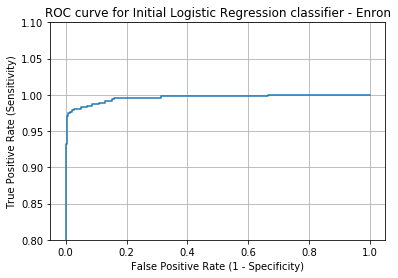

In [31]:
#ROC curve
import matplotlib.pyplot as plt
y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Logistic Regression classifier - Enron')
plt.ylim([0.8, 1.1])
plt.plot( label='ROC curve (area = )')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_initial_auc= metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning Logistic regression using grid search

In [32]:
%%time
clf = LogisticRegression()
param_grid = { 'C' : np.linspace(0.001, 10, 100)}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_C = grid_search.best_estimator_.C


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 9.697000000000001}
CPU times: user 1min 48s, sys: 739 ms, total: 1min 49s
Wall time: 55 s


In [33]:
print(best_C)
tunedLG = LogisticRegression(C = best_C)

9.697000000000001


In [34]:
tunedLG.fit(email_train_tf, spam_train)

LogisticRegression(C=9.697000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [35]:
result1a = tunedLG.predict(email_val_tf)

In [36]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

lg_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9915302089215132


In [37]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9915302089215132
[[1298    3]
 [  12  458]]


In [38]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.999695815003189


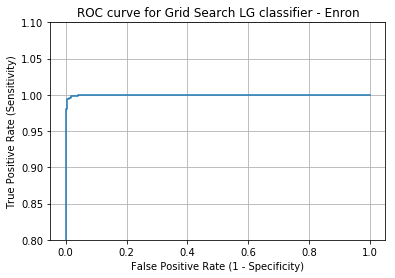

In [39]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedLG.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search LG classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning logistic regression using random search 

In [13]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression()
param_grid = { 'C' : np.linspace(0.001, 10, 100000)}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 3, scoring = 'accuracy', n_iter = 50, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_C = RandomizedSearch.best_estimator_.C

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 8.164165241652416}
CPU times: user 6.52 s, sys: 75.1 ms, total: 6.59 s
Wall time: 3.54 s


In [14]:
print(best_C)
tunedLG = LogisticRegression(C = best_C)

8.164165241652416


In [15]:
tunedLG.fit(email_train_tf, spam_train)

LogisticRegression(C=8.164165241652416, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [16]:
result1a = tunedLG.predict(email_val_tf)

In [17]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

lg_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9828473413379074


In [26]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9828473413379074
[[490   0]
 [ 10  83]]


In [27]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


In [28]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedLG.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search LG classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

0.9994075049374589


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = clf.predict(email_val_tf)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
rf_default = metrics.accuracy_score(spam_val, result1)

In [ ]:
confusion = metrics.confusion_matrix(spam_test, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

In [ ]:
#ROC curve

y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Random Forest classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning Random forest using grid search

In [25]:
clf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

param_grid = { 'n_estimators' : n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_n = grid_search.best_estimator_.n_estimators
best_max_depth = grid_search.best_estimator_.max_depth
best_min_samples_leaf = grid_search.best_estimator_.min_samples_leaf

KeyboardInterrupt: 

In [26]:
## print(best_n, best_max_depth, best_min_samples_leaf)
tunedRF = RandomForestClassifier(n_estimators = 1200, max_depth = 60,  min_samples_leaf = 1)

In [27]:
tunedRF.fit(email_train_tf, spam_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
result1a = tunedRF.predict(email_val_tf)

In [29]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
rf_grid_acc = (metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9777015437392796


In [30]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9777015437392796
[[489   1]
 [ 12  81]]


In [31]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9989247311827958


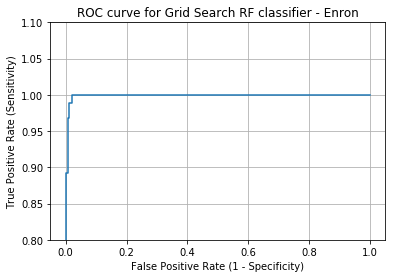

In [32]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedRF.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search RF classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_grid_score = metrics.roc_auc_score(spam_val, y_pred_prob)

## Tuning Random forest using random search

In [29]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 5000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]

param_grid = { 'n_estimators' : n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 5, scoring = 'accuracy', n_iter = 10, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_n = RandomizedSearch.best_estimator_.n_estimators
best_max_depth = RandomizedSearch.best_estimator_.max_depth
best_min_samples_leaf = RandomizedSearch.best_estimator_.min_samples_leaf

KeyboardInterrupt: 

In [34]:
## print(best_n, best_max_depth, best_min_samples_leaf)
tunedRF = RandomForestClassifier(n_estimators = 3000, max_depth = 100,  min_samples_leaf = 1)

In [35]:
tunedRF.fit(email_train_tf, spam_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
result1a = tunedRF.predict(email_val_tf)

In [37]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
rf_grid_acc = (metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9777015437392796


In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

In [ ]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


In [ ]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedRF.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search RF classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_grid_score = metrics.roc_auc_score(spam_val, y_pred_prob)

### K neighbours classifier

In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
# fit tf-idf representation to NB model
neigh.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = neigh.predict(email_val_tf)

In [115]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
knn_default = metrics.accuracy_score(spam_val, result1)

Accuracy on test set:
0.9897084048027445


In [116]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

[[485   5]
 [  1  92]]


0.9962914197937239


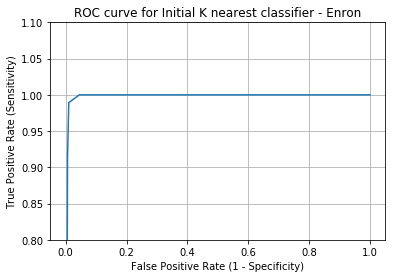

In [117]:
#ROC curve

y_pred_prob = neigh.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial K nearest classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
knn_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning K neighbours using grid search

In [118]:
clf = KNeighborsClassifier()
k_range = range(1, 10)
weight_options = ['uniform', 'distance']
param_grid = { 'n_neighbors' :k_range, 'weights' :weight_options}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_k = grid_search.best_estimator_.n_neighbors
best_wt = grid_search.best_estimator_.weights

{'n_neighbors': 8, 'weights': 'distance'}


In [119]:
print(best_k, best_wt)
tunedKNN = KNeighborsClassifier(n_neighbors = best_k, weights= best_wt)

8 distance


In [120]:
tunedKNN.fit(email_train_tf, spam_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance')

In [121]:
result1a = tunedKNN.predict(email_val_tf)

In [122]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
knn_grid_acc=(metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9879931389365352


In [123]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9879931389365352
[[484   6]
 [  1  92]]


In [124]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9989466754443713


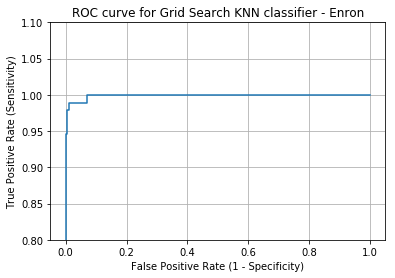

In [125]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedKNN.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search KNN classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
knn_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning K neighbours using random search

In [36]:
%%time
from sklearn.model_selection import RandomizedSearchCV

clf = KNeighborsClassifier()
k_range = range(1, 20)
weight_options = ['uniform', 'distance']
param_grid = { 'n_neighbors' :k_range, 'weights' :weight_options}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 5, scoring = 'accuracy', n_iter = 10, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_k = RandomizedSearch.best_estimator_.n_neighbors
best_wt = RandomizedSearch.best_estimator_.weights

{'weights': 'distance', 'n_neighbors': 17}
CPU times: user 6.86 s, sys: 349 ms, total: 7.21 s
Wall time: 7.4 s


In [37]:
print(best_k, best_wt)
tunedKNN = KNeighborsClassifier(n_neighbors = best_k, weights= best_wt)

17 distance


In [38]:
tunedKNN.fit(email_train_tf, spam_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='distance')

In [39]:
result1a = tunedKNN.predict(email_val_tf)

In [40]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
knn_grid_acc=(metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9862778730703259


In [41]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9862778730703259
[[484   6]
 [  2  91]]


In [42]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9983541803818302


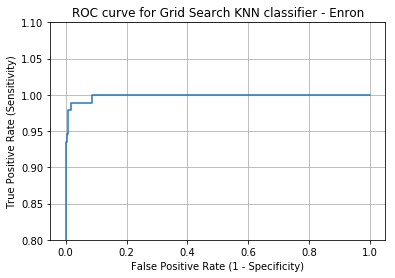

In [43]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedKNN.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search KNN classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
knn_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
m = AdaBoostClassifier(base_estimator=MultinomialNB(alpha=0.024770763559917114), n_estimators=100)
m.fit(email_train_tf, spam_train)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=MultinomialNB(alpha=0.024770763559917114, class_prior=None, fit_prior=True),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [25]:
result1a = m.predict(email_val_tf)
print(metrics.accuracy_score(spam_val, result1a))

0.9897084048027445


## Plots 

### Default Accuracy

In [ ]:
model_accs_default = {'NB': nb_default, 'SVM': svm_default, 'LG': lg_default, 'RF': rf_default, 'KNN' : knn_default}
print(model_accs_default)


In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_accs_default)), model_accs_default.values(), align='center')

plt.xticks(range(len(model_accs_default)), model_accs_default.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(model_accs_default)), model_accs_default.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.80,1.0])
bl = plt.bar(range(len(model_accs_default)), model_accs_default.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')


plt.title('Initial Classifier Model Accuracies - Enron')

In [31]:

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


m = VotingClassifier(
    estimators=[('lr', LogisticRegression()), 
                ('rf', RandomForestClassifier()), 
                ('gnb', MultinomialNB())], 
    voting='soft')
m.fit(email_train_tf, spam_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...            warm_start=False)), ('gnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [32]:
result1a = m.predict(email_val_tf)
print(metrics.accuracy_score(spam_val, result1a))

0.9639794168096055


### Default AUC

In [ ]:
models_default_auc = {'NB': nb_initial_auc, 'SVM': svm_initial_auc, 'LG': lg_initial_auc, 'RF': rf_initial_auc, 'KNN' : knn_initial_auc}
print(models_default_auc)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(models_default_auc)), models_default_auc.values(), align='center')

plt.xticks(range(len(models_default_auc)), models_default_auc.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(models_default_auc)), models_default_auc.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.980,1.01])
bl = plt.bar(range(len(models_default_auc)), models_default_auc.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')

plt.title('Initial Classifier AUC - Enron')

### Grid search Aaccuracy

In [77]:
model_accs_grid = {'NB': 99.142, 'SVM':99.113, 'LG':99.051, 'RF': 98.250, 'KNN' : 98.891}
print(model_accs_grid)

{'NB': 99.142, 'SVM': 99.113, 'LG': 99.051, 'RF': 98.25, 'KNN': 98.891}


Text(0.5, 1.0, 'Particle Swarm Optimization Accuracies - Enron')

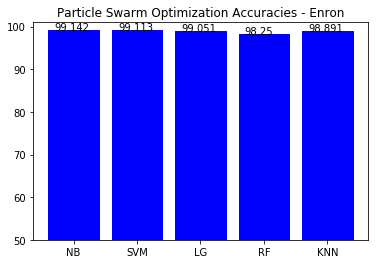

In [79]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_accs_grid)), model_accs_grid.values(), align='center')

plt.xticks(range(len(model_accs_grid)), model_accs_grid.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(model_accs_grid)), model_accs_grid.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([50,101])
bl = plt.bar(range(len(model_accs_grid)), model_accs_grid.values(), align='center');
bl[0].set_color('b')
bl[1].set_color('b')
bl[2].set_color('b')
bl[3].set_color('b')
bl[4].set_color('b')

plt.title('Particle Swarm Optimization Accuracies - Enron')

### Grid search AUC

In [ ]:
models_grid_auc = {'NB': nb_grid_auc, 'SVM': svm_grid_auc, 'LG': lg_grid_auc, 'RF': rf_grid_score, 'KNN' : knn_grid_auc}
print(models_grid_auc)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(models_grid_auc)), models_grid_auc.values(), align='center')

plt.xticks(range(len(models_grid_auc)), models_grid_auc.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(models_grid_auc)), models_grid_auc.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.980,1.01])
bl = plt.bar(range(len(models_grid_auc)), models_grid_auc.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')

plt.title('Grid Search Classifier AUC - Enron')

In [34]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(17072, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 email_train_tf, spam_train,
 epochs= 2,
 batch_size = 500,
 validation_data = (email_val_tf, spam_val)
)
print("Test-Accuracy:", np.mean(results.history["val_acc"]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                853650    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 858,801
Trainable params: 858,801
Non-trainable params: 0
_________________________________________________________________
Inst